<a href="https://colab.research.google.com/github/achen32/Github_Exercise/blob/main/term_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with Terms and Documents

This exercise starts off with term statistics computations and graphing. In the final section (for CS6200 students), you collect new documents to experiment with.

Read through this Jupyter notebook and fill in the parts marked with `TODO`.

## Sample Data

Start by looking at some sample data. We donwload the counts of terms in documents for the first one million tokens of a newswire collection.

In [1]:
!wget -O ap201001.json.gz https://github.com/dasmiq/cs6200-documents/blob/main/ap201001.json.gz?raw=true
!gunzip ap201001.json.gz

--2025-01-26 21:06:53--  https://github.com/dasmiq/cs6200-documents/blob/main/ap201001.json.gz?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/dasmiq/cs6200-documents/raw/refs/heads/main/ap201001.json.gz [following]
--2025-01-26 21:06:53--  https://github.com/dasmiq/cs6200-documents/raw/refs/heads/main/ap201001.json.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dasmiq/cs6200-documents/refs/heads/main/ap201001.json.gz [following]
--2025-01-26 21:06:53--  https://raw.githubusercontent.com/dasmiq/cs6200-documents/refs/heads/main/ap201001.json.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185

We convert this file with one JSON record on each line to a list of dictionaries.

In [2]:
import json
rawfile = open('ap201001.json')
terms = [json.loads(line) for line in rawfile]

Here are the first ten records, showing the count of each term for each document and field. In this dataset, field only takes the values `body` or `title`.

In [3]:
terms[1:10]

[{'id': 'APW_ENG_20100101.0001', 'field': 'body', 'term': 'about', 'count': 1},
 {'id': 'APW_ENG_20100101.0001', 'field': 'body', 'term': 'abuse', 'count': 1},
 {'id': 'APW_ENG_20100101.0001',
  'field': 'body',
  'term': 'academy',
  'count': 1},
 {'id': 'APW_ENG_20100101.0001',
  'field': 'body',
  'term': 'accused',
  'count': 2},
 {'id': 'APW_ENG_20100101.0001',
  'field': 'body',
  'term': 'actress',
  'count': 1},
 {'id': 'APW_ENG_20100101.0001', 'field': 'body', 'term': 'ad', 'count': 1},
 {'id': 'APW_ENG_20100101.0001', 'field': 'body', 'term': 'after', 'count': 1},
 {'id': 'APW_ENG_20100101.0001',
  'field': 'body',
  'term': 'agenda',
  'count': 1},
 {'id': 'APW_ENG_20100101.0001',
  'field': 'body',
  'term': 'agreed',
  'count': 1}]

Each record has four fields:
* `id`, with the identifier for the document;
* `field`, with the region of the document containing a given term;
* `term`, with the lower-cased term; and
* `count`, with the number of times each term occurred in that field and document.

## Computing Term Statistics


If we look at the most frequent terms for a given document, we mostly see common function words, such as `the`, `and`, and `of`. Start exploring the dataset by computing some of these basic term statistics. You can make your life easier using data frame libraries such as `pandas`, core python libraries such as `collections`, or just simple list comprehensions.

Feel free to define helper functions in your code before computing the statistics we're looking for.

In [10]:
import pandas as pd

df = pd.DataFrame(terms)

# Filter data by document ID
filtered_data = df[df['id'] == 'APW_ENG_20100101.0001']

# Sort by the 'count' field in descending order
sorted_data = filtered_data.sort_values(by='count', ascending=False)

# Get top 10 terms and their counts
top_10_terms = sorted_data[['term', 'count']].head(10)

# Print terms with their counts
for _, row in top_10_terms.iterrows():
    print(f"{row['term']}: {row['count']}")


a: 16
the: 11
of: 10
to: 10
brooks: 10
and: 10
in: 9
he: 9
gomez: 8
said: 6


In [8]:
# TODO: Print the 10 terms with the highest total count in the corpus.

# Group by 'term' and sum the 'count' values
grouped_data = df.groupby('term')['count'].sum()

# Sort in descending order
sorted_data = grouped_data.sort_values(ascending=False)

# Extract the top 10 terms
top_10_terms = sorted_data.head(10)

print(top_10_terms)

term
the     62216
to      26931
in      25659
a       23383
of      22326
and     22125
said    10888
for      9716
on       9382
that     8942
Name: count, dtype: int64


Raw counts may not be the most informative statistic. One common improvement is to use *inverse document frequency*, the inverse of the proportion of documents that contain a given term.

In [14]:
# TODO: Compute the number of distinct documents in the collection.
N = df['id'].nunique()
print(f"# of distinct documents (N): {N}")


# TODO: Compute the number of distinct documents each term appears in
# and store in a dictionary.
# df = dict()

dict = {}

for term, group in df.groupby('term'):
    dict[term] = group['id'].nunique()


# of distinct documents (N): 2778


In [16]:
# TODO: Print the relative document frequency of 'the',
# i.e., the number of documents that contain 'the' divided by N.

frequency_the = dict['the'] / N
print(frequency_the)

0.9704823614110871


Empricially, we usually see better retrieval results if we rescale term frequency (within documents) and inverse document frequency (across documents) with the log function. Let the `tfidf` of term _t_ in document _d_ be:
```
tfidf(t, d) = log(count(t, d) + 1) * log(N / df(t))
```

Later in the course, we will show a probabilistic derivation of this quantity based on smoothing language models.

In [20]:
# TODO: Compute the tf-idf value for each term in each document.
# Take the raw term data and add a tfidf field to each record.

import numpy as np

# Function to compute tf-idf
def compute_tfidf(row, N, term_document_count):
    # Extract (count(t, d))
    tf = row['count']

    # Extract (df(t))
    df_t = term_document_count.get(row['term'], 0)

    # Compute tf-idf using the given formula
    if df_t > 0:
        tfidf = np.log(tf + 1) * np.log(N / df_t)
    else:
        tfidf = 0

    return tfidf

# Compute the TF-IDF for each row
df['tfidf'] = df.apply(compute_tfidf, axis=1, N=N, term_document_count=dict)

df.head()

,id,field,term,count,tfidf
0,APW_ENG_20100101.0001,body,a,16,0.219394
1,APW_ENG_20100101.0001,body,about,1,0.656793
2,APW_ENG_20100101.0001,body,abuse,1,3.237961
3,APW_ENG_20100101.0001,body,academy,1,3.419818
4,APW_ENG_20100101.0001,body,accused,2,2.885155


In [22]:
# TODO: Print the 20 term-document pairs with the highest tf-idf values.

top_20_terms = df.sort_values(by='tfidf', ascending=False).head(20)

print(top_20_terms)



                           id field         term  count      tfidf
52727   APW_ENG_20100103.0028  body      guarani     24  23.292878
199263  APW_ENG_20100105.0061  body   nomination     95  22.519372
234566  APW_ENG_20100105.0446  body      methane     15  21.985205
192483  APW_ENG_20100105.0014  body    greyhound     14  21.473448
48925   APW_ENG_20100103.0015  body       kheire     14  21.473448
433679  APW_ENG_20100107.0036  body  shakespeare     18  21.306960
199179  APW_ENG_20100105.0061  body        guild     28  20.667543
342740  APW_ENG_20100106.0428  body  shakespeare     16  20.502093
305769  APW_ENG_20100106.0075  body        magna     12  20.338731
21195   APW_ENG_20100102.0197  body      elkhart     12  20.338731
426716  APW_ENG_20100106.1325  body       sutton     20  19.920895
107822  APW_ENG_20100104.0043  body        tohti     11  19.704034
192485  APW_ENG_20100105.0014  body   greyhounds     11  19.704034
522469  APW_ENG_20100107.0928  body       minhas     11  19.70

## Plotting Term Distributions

Besides frequencies and tf-idf values within documents, it is often helpful to look at the distrubitions of word frequencies in the whole collection. In class, we talk about the Zipf distribution of word rank versus frequency and Heaps' Law relating the number of distinct words to the number of tokens.

We might examine these distributions to see, for instance, if an unexpectedly large number of very rare terms occurs, which might indicate noise added to our data.

In [24]:
# TODO: Compute a list of the distinct words in this collection and sort it in descending order of frequency.
# Thus frequency[0] should contain the word "the" and the count 62216.

term_frequency = df.groupby('term')['count'].sum()

frequency = term_frequency.sort_values(ascending=False)

frequency.head()

,count
term,
the,62216
to,26931
in,25659
a,23383
of,22326


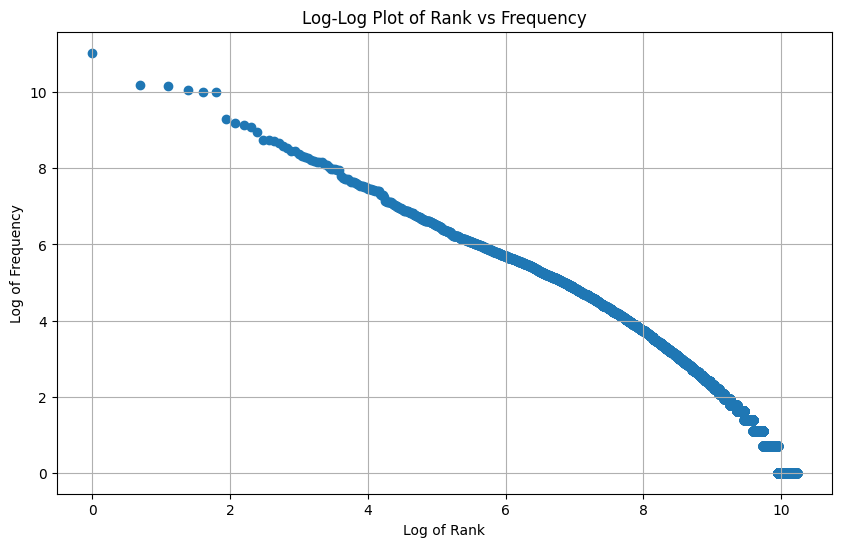

In [29]:
# TODO: Plot a graph of the log of the rank (starting at 1) on the x-axis,
# against the log of the frequency on the y-axis. You may use the matplotlib
# or other library.

import matplotlib.pyplot as plt

ranked_terms = frequency.reset_index()

ranked_terms['log_rank'] = np.log(np.arange(1, len(ranked_terms) + 1))
ranked_terms['log_frequency'] = np.log(ranked_terms['count'])

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(ranked_terms['log_rank'], ranked_terms['log_frequency'], marker='o')
plt.xlabel('Log of Rank')
plt.ylabel('Log of Frequency')
plt.title('Log-Log Plot of Rank vs Frequency')
plt.grid(True)
plt.show()


In [38]:
# TODO: Compute the number of tokens in the corpus.
# Remember to count each occurrence of each word. For instance, the 62,216
# instances of "the" will all count here.
total_tokens = df['count'].sum()
print(total_tokens)


1000000


In [39]:
# TODO: Compute the proportion of tokens made up by the top 10 most
# frequent words.

# Sum up count for top 10 most frequent words
top_10_terms = ranked_terms.head(10)
top_10_tokens = top_10_terms['count'].sum()

proportion_top_10 = top_10_tokens / total_tokens
print(proportion_top_10)


0.221568


In [51]:
# TODO: Compute the proportion of tokens made up by the words that occur
# exactly once in this collection.

once_terms = ranked_terms[ranked_terms['count'] == 1]
once_tokens = once_terms['count'].sum()
proportion_once = once_tokens / total_tokens

print(proportion_once)


0.006641


## Acquiring New Documents (for CS6200)

For this assignment so far, you've worked with data that's already been extracted, tokenized, and counted. In this final section, you'll explore acquiring new data.

One common way of acquiring data is through application programming interfaces (APIs) to various databases. The Library of Congress's [_Chronicling America_](https://chroniclingamerica.loc.gov/) site aggregates digitized US newspapers from the past two hundred years, such as the [_Seattle Star_](https://chroniclingamerica.loc.gov/lccn/sn87093407/1925-01-17/ed-1/seq-1/) from 100 years ago.

You can use [the API](https://chroniclingamerica.loc.gov/about/api/) to retrieve JSON data listing all issues of the _Seattle Star_: https://chroniclingamerica.loc.gov/lccn/sn87093407.json

Note the list in the `issues` field. For example, here is the record for the January 17, 1925, issue: https://chroniclingamerica.loc.gov/lccn/sn87093407/1925-01-17/ed-1.json

In that issue record, you'll see records for each page, e.g.: https://chroniclingamerica.loc.gov/lccn/sn87093407/1925-01-17/ed-1/seq-1.json

And inside that page record, you'll see links to data about that page in various data formats, such as JPEG, PDF, and plain text, which is what we want here: https://chroniclingamerica.loc.gov/lccn/sn87093407/1925-01-17/ed-1/seq-1/ocr.txt

This plain text was transcribed from the old page images using optical character recognition (OCR) models, and so contains errors.

Your task is to acquire and analyze the issues of the _Seattle Star_ from the month of January, 1925, i.e., the issues with a date field that starts with `1925-01`. This should be about the same amount of data as the million words from the Associated Press you analyzed in the last section.

**TODO**: Write code that calls the _Chronicling America_ API to download and extract the text from the _Seattle Star_ from January 1925. You can use the `json` library from above and any other libraries you wish to fetch data from URLs. As you would when working with any production API, you may need to limit your rate of requests.

In [ ]:
# TODO: Data acquisition code here.

**TODO**: Write code to tokenize the text and count the resulting terms in each document. Since this data comes from automatically transcribing printed pages, some words may be hyphenated across line breaks. There is more than one right way to tokenize this data, so add comments to your code documenting your choices.

In [ ]:
# TODO: Tokenization code here.

**TODO**: Plot a graph of the log rank against log frequency for your collection, as you did for the sample collection above.

In [ ]:
# TODO: Plotting code here.

**TODO**: What do you observe about the differences between the distributions of the Associated Press and Seattle Star collections? In this text box, give some possible reasons for these differences.